#House Price Prediction Using Regression

##Setup: Importing Libraries & Kaggle API

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder #Standardization of numerical & conversion of categorical variables
from sklearn.linear_model import LinearRegression #Linear Regression model
import xgboost as xgb #XGBoost model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #Evaluation metrics

import os #File management

sns.set_style('whitegrid')

##Data Loading via Kaggle API

Downloading data directly from kaggle

In [2]:
#Install Kaggle library
!pip install -q Kaggle

#Use Colab's File uploader
from google.colab import files
print("Upload kaggle.json file obtained after creating a token")
files.upload()

#Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
#Copy the uploaded .json file to required directory
!cp kaggle.json ~/.kaggle/
#Setup correct permission for file
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully")

Upload kaggle.json file obtained after creating a token


Saving kaggle.json to kaggle (1).json
Kaggle API configured successfully


In [3]:
# Download the dataset from the 'house-prices-advanced-regression-techniques' competition
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [4]:
#Load train & test dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#Set the ID column as the index for consistency
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

print("Dataframes loaded successfully")
train_df.head(2)

Training data shape: (1460, 80)
Testing data shape: (1459, 79)
Dataframes loaded successfully


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

##EDA

###EDA on Target Varible (SalePrice)

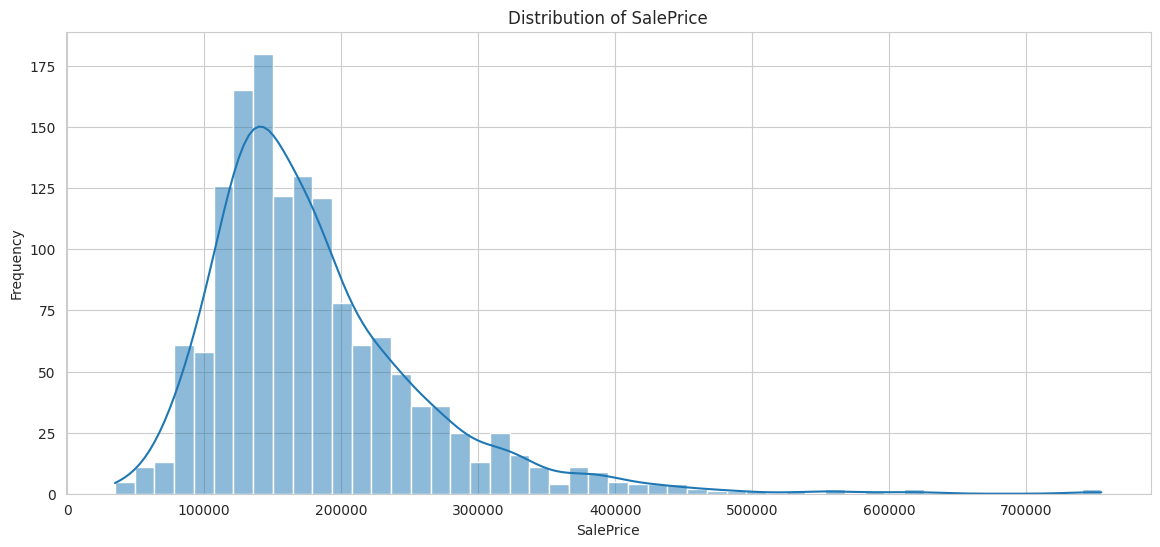

Skewness of SalePrice: 1.8828757597682129


In [5]:
plt.figure(figsize=(14,6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

#To check normal distribution of numerical target variable: SalePrice. The model excludes the rows with missing values and only train_df has the target column SalePrice
#Normality distribution of variables is one of the assumptions/requirements before modeling building
print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

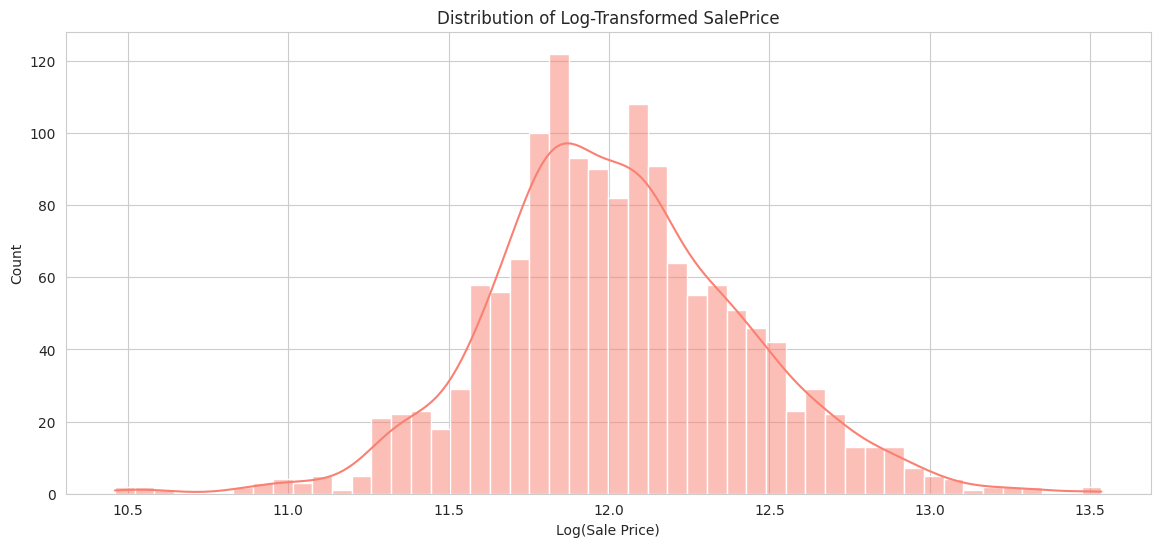

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [6]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice']) #Log transformation appliead to obtain normal distribution in target variable

plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='salmon')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

###EDA on Feature Variables

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')


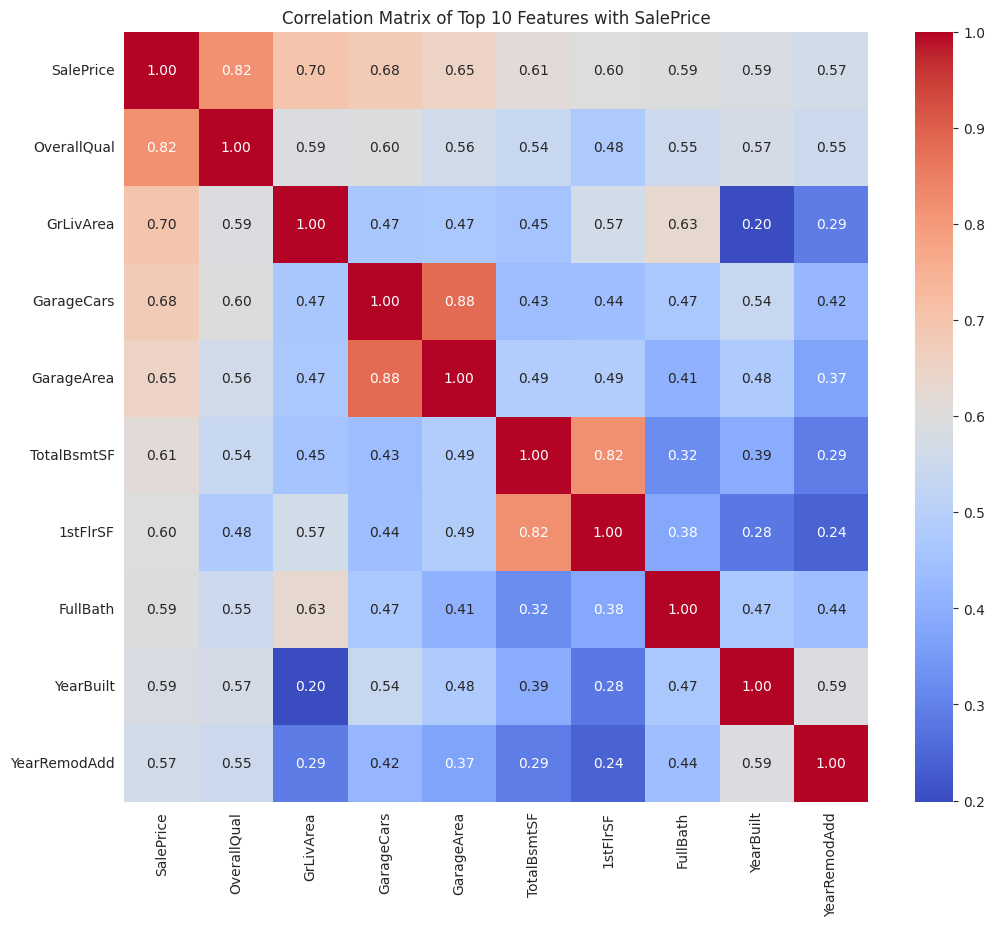

In [7]:
# Find the top 10 features most correlated with SalePrice
corr_matrix = train_df.corr(numeric_only=True) #corr() to get linear relationship between pairs of numerical features (+1: positive correlation, -1 negative correlation, 0: no correlation)
top_corr_features = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index #nlargest returns a dataframe with rows having 10 rows with largest values in Sales_Price column. SalesPrice.index will returns column names with highest positive correlation with SalePrice target variable
print(top_corr_features)
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

The heatmap shows that OverallQual (Overall Quality), GrLivArea (Above Ground Living Area), and GarageCars/GarageArea are the most positively correlated features with SalePrice.

##Data Preprocessing & Feature Engineering

In [8]:
#Combine train & test data to ensure consistency while preprocesing data
all_data = pd.concat((train_df.loc[:,:'SaleCondition'], test_df.loc[:,:'SaleCondition'])) #excluding target SalePrice feature/column

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

###1. Handling Missing Values

In [10]:
missing_data = all_data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]
print(missing_data)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [11]:
num_missing_cols_data = all_data.select_dtypes(include=['int64', 'float64']).isnull().sum().sort_values(ascending=False)
num_missing_cols_data = num_missing_cols_data[num_missing_cols_data > 0]
print(num_missing_cols_data)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
BsmtFinSF2        1
GarageArea        1
TotalBsmtSF       1
BsmtFinSF1        1
BsmtUnfSF         1
dtype: int64


In [12]:
# Impute numerical features with 0 where less values are missing. Filling missing values as 0 in GarageYrBlt assuming 0 as no garage built consistent with GarageArea and cars=0
numerical_cols_to_impute_zero = ['GarageYrBlt','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [13]:
# Check missing values in numerical columns after imputation with 0
all_data[numerical_cols_to_impute_zero].isnull().sum()

,0
GarageYrBlt,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [14]:
all_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,276
80.0,137
70.0,133
50.0,117
75.0,105
...,...
155.0,1
126.0,1
200.0,1


In [15]:
#Impute LotFrontage values based on the neighborhood to get similar LotFrontage values
if all_data['LotFrontage'].isnull().any():
  all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) #transform used to keep same shape as the original column.

In [16]:
#Checking missing values in object datatype
cat_missing_cols_data = all_data.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
cat_missing_cols_data = cat_missing_cols_data[cat_missing_cols_data > 0]
print(cat_missing_cols_data)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
KitchenQual        1
Electrical         1
dtype: int64


In [17]:
#For columns with high missing values, missing values will be filled with None
categorical_cols_to_impute_none = ['Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Alley']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

#For columns, with low missing values, fill it with mode/highest frequency
for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
  if col in all_data.columns:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [18]:
#To check if any null values are remaining throughout the dataset
all_data.isnull().sum().sum()

np.int64(0)

###2. Feature Engineering

In [19]:
all_data[['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']].head(2)

,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,
1,2,1,1.0,0.0
2,2,0,0.0,1.0


In [20]:
#Total square footage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#Total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


###3. Categorical Encoding

In [21]:
#Convert categorical variables into numeric using one-hot encoding (presence/absence of that category) for model building
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

In [22]:
all_data.shape

(2919, 262)

##Model Building & Training

In [23]:
#Train test split
X = all_data[:len(train_df)] #Feature variables of all_data, include rows equalling to length of the train_df
y = train_df['SalePrice'] #Only present in train_df and is log_transformed
X_test_final = all_data[len(train_df):]

#Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#Standardization (mean of 0 and a SD of 1) of numerical feature variables to avoid domination of large scale features over small scale features is required
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [25]:
#Fitting Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

In [26]:
#Fitting XGBoost model (L1, L2 regularization, handles missing values, supports tree pruning to improve model performance & reduce overfitting)
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

#XGBoost generally doesn't require scaling. Use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

In [27]:
#Using GridSearchCV for hyperparameter tuning. Wrapper model around ML model.
#ML Model: learns patterns from data. GridSearchCV: runs many versions of that model with different hyperparameters, compares them, and picks the best one.
from sklearn.model_selection import GridSearchCV

#Base XGB model
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

#Define parameter grids
param_grid = {
    'n_estimators': [500, 1000, 1500], #number of trees
    'learning_rate': [0.01, 0.05, 0.1], #shrinkage step
    'max_depth': [3, 4, 5], #tree depth
    'subsample': [0.8, 1.0], #% of data sampled per tree
    'colsample_bytree': [0.8, 1.0], #% of features sampled per tree
}

#Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  #evaluation metric
    cv=3,          #3-fold cross-validation
    verbose=1,     #show progress
    n_jobs=-1      #use all CPU cores
)

#Fit on training data
grid_search.fit(X_train, y_train)

#Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_
print(best_model)

y_pred_grid = best_model.predict(X_val)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.8}
Best RMSE: 0.12308941710686955
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)


In [28]:
#RandomizedSearch CV hyper parameter tuning wrappping XGBoost model
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=param_grid,
    n_iter=20,   # test 20 random combos instead of all
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

best_model = random_search.best_estimator_
print(best_model)

y_pred_random = best_model.predict(X_val)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best RMSE: 0.12308941710686955
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)


In [29]:
#Ensemble technique: combine multiple models to make prediction

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

#Train models
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
ridge = Ridge(alpha=10).fit(X_train, y_train)
xgbr.fit(X_train, y_train)

#Predict
y_pred_rf = rf.predict(X_val)
y_pred_ridge = ridge.predict(X_val)
y_pred_xgb = xgbr.predict(X_val)

#Average ensemble
final_pred = (y_pred_xgb + y_pred_rf + y_pred_ridge) / 3

##Model Evaluation

In [30]:
def evaluate_model(y_val, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

evaluate_model(y_val, y_pred_lr, "Linear Regression")
evaluate_model(y_val, y_pred_xgb, "XGBoost")
evaluate_model(y_val, y_pred_grid, "GridSearch")
evaluate_model(y_val, y_pred_random, "RandomSearch")
evaluate_model(y_val, final_pred, "Ensemble (XGB + RF + Ridge)")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1315
MAE:  0.0858
R-squared: 0.9073

--- GridSearch Performance ---
RMSE: 0.1335
MAE:  0.0867
R-squared: 0.9046

--- RandomSearch Performance ---
RMSE: 0.1335
MAE:  0.0867
R-squared: 0.9046

--- Ensemble (XGB + RF + Ridge) Performance ---
RMSE: 0.1317
MAE:  0.0847
R-squared: 0.9071



XGBoost algorithm and Ensemble model provide better accuracy and comparatively lower mean squared error values.